In [12]:
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt  
import seaborn as sns
from numpy import set_printoptions
from statistics import mean
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
import numpy as np

In [13]:
preprocessed_df = pd.read_csv("../preprocessing/preprocessedData.csv")

In [14]:
categorical_features = ['VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorType_Returning_Visitor', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep']
target = "Revenue"

preprocessed_df[categorical_features] = preprocessed_df[categorical_features].astype('category') 
preprocessed_df[target] = preprocessed_df[target].astype('category') 

In [15]:
preprocessed_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Unnamed: 0                     12330 non-null  int64   
 1   PageValues                     12330 non-null  float64 
 2   ExitRates                      12330 non-null  float64 
 3   ProductRelated                 12330 non-null  float64 
 4   Administrative                 12330 non-null  float64 
 5   Informational                  12330 non-null  float64 
 6   SpecialDay                     12330 non-null  float64 
 7   Revenue                        12330 non-null  category
 8   Month_Aug                      12330 non-null  category
 9   Month_Dec                      12330 non-null  category
 10  Month_Feb                      12330 non-null  category
 11  Month_Jul                      12330 non-null  category
 12  Month_June                     1

In [16]:
# Split dataframe into x and y

X = preprocessed_df.drop(columns=["Revenue"])
y = preprocessed_df["Revenue"].values

# Oversampling

In [17]:
# Class count
count_class_0, count_class_1 = preprocessed_df['Revenue'].value_counts()

# Divide by class
df_class_0 = preprocessed_df[preprocessed_df['Revenue'] == 0]
df_class_1 = preprocessed_df[preprocessed_df['Revenue'] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over['Revenue'].value_counts())

X = df_test_over.drop(columns=["Revenue"])
y = df_test_over["Revenue"].values

Random over-sampling:
1    10422
0    10422
Name: Revenue, dtype: int64


In [18]:
# Split dataframe into train and test data
# Note: Stratify preserves the propotion of Revenue of T/F in the testing and training sets

f1_scores_macro = []
recalls_macro = []
precisions_macro = []
f1_scores_weighted = []
recalls_weighted = []
precisions_weighted = []
accuracies = []

y_preds = []
y_pred_probs = []
y_trues = []

X_tests = []

for i in range(10):
    print("__________________________________________________________________________________Iteration:"+str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    y_trues.append(y_test)

    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors=13, algorithm = 'brute', metric='manhattan', weights='uniform')

    # Fit the classifier to the data
    knn.fit(X_train, y_train)

    # Make predications on the test data
    y_pred = knn.predict(X_test)
    y_preds.append(y_pred)
    y_pred_prob = knn.predict_proba(X_test)[:,1]
    y_pred_probs.append(y_pred_prob)
    
    # Scores
    f1_scores_macro.append(f1_score(y_test, y_pred, average='macro'))
    recalls_macro.append(recall_score(y_test, y_pred, average='macro'))
    precisions_macro.append(precision_score(y_test, y_pred, average='macro'))
    f1_scores_weighted.append(f1_score(y_test, y_pred, average='weighted'))
    recalls_weighted.append(recall_score(y_test, y_pred, average='weighted'))
    precisions_weighted.append(precision_score(y_test, y_pred, average='weighted'))
    accuracies.append(accuracy_score(y_test, y_pred))
    
    # Print some results
    print('\nClassification Report                       : ')
    print(classification_report(y_test, y_pred))

__________________________________________________________________________________Iteration:0

Classification Report                       : 
              precision    recall  f1-score   support

           0       0.70      0.67      0.69      3127
           1       0.69      0.72      0.70      3127

    accuracy                           0.69      6254
   macro avg       0.70      0.69      0.69      6254
weighted avg       0.70      0.69      0.69      6254

__________________________________________________________________________________Iteration:1

Classification Report                       : 
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      3127
           1       0.69      0.72      0.70      3127

    accuracy                           0.70      6254
   macro avg       0.70      0.70      0.70      6254
weighted avg       0.70      0.70      0.70      6254

______________________________________________________________

In [19]:
print("Average Accuracy: "+str(mean(accuracies)))
print("Average F1-Score (macro): "+str(mean(f1_scores_macro)))
print("Average F1-Score (weighted): "+str(mean(f1_scores_weighted)))
print("Average Recall (macro): "+str(mean(recalls_macro)))
print("Average Recall (weighted): "+str(mean(recalls_weighted)))
print("Average Precision (macro): "+str(mean(precisions_macro)))
print("Average Precision (weighted): "+str(mean(precisions_weighted)))

Average Accuracy: 0.6966421490246242
Average F1-Score (macro): 0.6963886350160914
Average F1-Score (weighted): 0.6963886350160914
Average Recall (macro): 0.6966421490246242
Average Recall (weighted): 0.6966421490246242
Average Precision (macro): 0.6973036038615756
Average Precision (weighted): 0.6973036038615756


In [20]:
# Find the best model

# Draw confusion matrix with the best F1-Score
best_model_index = f1_scores_weighted.index(max(f1_scores_weighted))
print(best_model_index)
y_true = y_trues[best_model_index]
y_pred = y_preds[best_model_index]
y_pred_prob = y_pred_probs[best_model_index]

5


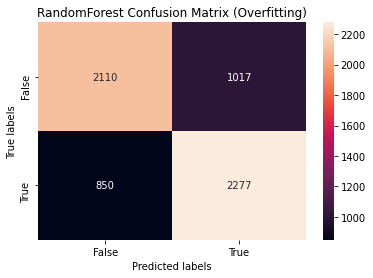

In [21]:
# Draw confusion matrix with the best F1-Score

# Confusion Matrix
cf_matrix = (confusion_matrix(y_true, y_pred))

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('RandomForest Confusion Matrix (Overfitting)'); 
ax.xaxis.set_ticklabels(['False', 'True']); ax.yaxis.set_ticklabels(['False', 'True']);

plt.savefig('../confusionMatrices/RandomForest_over_confusionMatrix.png')

In [22]:
data_y = {"Y_true":y_test, "Y_Pred": y_pred, "Y_Pred_Prob": y_pred_prob}

knn_df_y = pd.DataFrame(data_y) 
knn_df_y.to_csv("../predictions/randomForest_over_predictions.csv")

knn_df_y.shape

(6254, 3)